I am going to make two differennt models with housing price dataset.  
One is decision tree model, and the other is random forest model.  

Now, let's hope in the board!


**Step 1. Import housing data set and preprocessing**

In [50]:
# Load the houseprices data from Thinkful's database.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'  
postgres_pw = '7*.8G9QH21'  
postgres_host = '142.93.121.174'  
postgres_port = '5432'  
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

hp_df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()

hp_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


The features were selected by this analysis. Refer to this link https://github.com/feelopk/Thinkful/blob/master/M19.3_Meeting%20the%20assumptions%20of%20linear%20regression_Assignment%202%20(House%20prices).ipynb

But this time for the decision tree model, we have to choose the target values as categorical type.  
For this reason, I choose 'salecondition' feature as the target value.  

It would be interesting for us to look around the relationship between features and target value.

In [51]:
hp_sel = hp_df[['saleprice', 'lotfrontage', 'lotarea', 'masvnrarea', 'bsmtfinsf1', 
                'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'grlivarea', 'garagearea']]
hp_sel.replace(0, 1, inplace=True)
hp_sel.fillna(1, inplace=True)
hp_sellog = np.log(hp_sel)
hp_sellog_picked = hp_sellog[['saleprice', 'firstflrsf', 'grlivarea']]

X = hp_sellog_picked
Y = hp_df['salecondition']

**Step 2. Making Decision Tree Model**

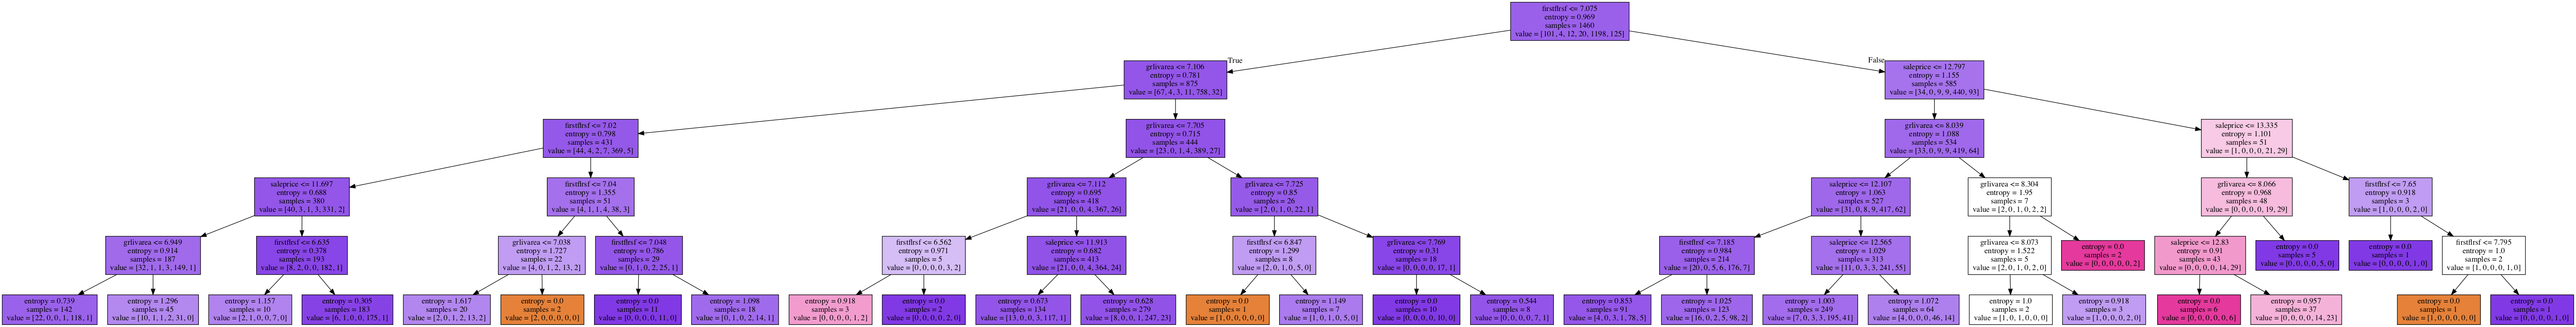

In [52]:
# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=5,
    random_state = 1337)

decision_tree.fit(X, Y)

# Another model for max_features = 2 case
decision_tree2 = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=5,
    random_state = 1337)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [53]:
# Let's check the performance of the decision tree model.

from sklearn.model_selection import cross_val_score
cross_val_score(decision_tree, X, Y, cv=10)
print(np.mean(cross_val_score(decision_tree, X, Y, cv=10)))

0.8186586964595002


In [54]:
# Let's check the performance of the decision tree model with max_features=2 parameter.

cross_val_score(decision_tree2, X, Y, cv=10)
print(np.mean(cross_val_score(decision_tree2, X, Y, cv=10)))

0.8199672789097248


Oh the 'decision_tree2' model's performance is slightly better than 'decision_tree' model.  
It's interesting. Then let's change "decision_tree2"'s parameter, max_depth from 5 to 10.

In [55]:
decision_tree2_10 = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=10,
    random_state = 1337)

cross_val_score(decision_tree2_10, X, Y, cv=10)
print(np.mean(cross_val_score(decision_tree2_10, X, Y, cv=10)))

0.7542071471327871


Oh, this is more interesting.
I assumed that the performance would be better than 'decision_tree2' model.
But my expectation was wrong.  

Then how about decision_tree with max_depth=10?  
Let's check it out!


In [56]:
decision_tree1_10 = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=10,
    random_state = 1337)

cross_val_score(decision_tree1_10, X, Y, cv=10)
print(np.mean(cross_val_score(decision_tree1_10, X, Y, cv=10)))

0.7588509876802325


Oh. The result of 'decision_tree1_10' is lower than 'decision_tree' model.  
But 'decision_tree1_10' performance is higher than 'decision_tree2_10' model.  

**It's quite interesting that max_features and max_depth parameter are not absolute criteria for the performances.**

**Step 3. Making Random Forest Model**

In [57]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, Y, cv=10)
print(np.mean(cross_val_score(rfc, X, Y, cv=10)))

0.7808101744669228


The performance of random forest is better than 'decision_tree1_10' and 'decision_tree2_10', but lower than 'decision_tree' and 'decision_tree2'

**Step 4. Runtime calculate; Random Forest model and Decision Tree model**

In [64]:
# Runtime calculator
import time
start_time = time.time()
print("The runtime of {} is {} seconds".format('Decision Tree Model', (time.time() - start_time)), '\n')

# Decision Tree Model 
cross_val_score(decision_tree, X, Y, cv=10)
print('The cross validation score of {} is {}'.format('Decision Tree Model', np.mean(cross_val_score(decision_tree, X, Y, cv=10))))

The runtime of Decision Tree Model is 4.887580871582031e-05 seconds 

The cross validation score of Decision Tree Model is 0.8186586964595002


In [65]:
# Decision Tree Model2
start_time = time.time()
print("The runtime of {} is {} seconds".format('Decision Tree2 Model', (time.time() - start_time)), '\n')

# Decision Tree Model 
cross_val_score(decision_tree2, X, Y, cv=10)
print('The cross validation score of {} is {}'.format('Decision Tree2 Model', np.mean(cross_val_score(decision_tree2, X, Y, cv=10))))

The runtime of Decision Tree2 Model is 5.3882598876953125e-05 seconds 

The cross validation score of Decision Tree2 Model is 0.8199672789097248


In [66]:
# Decision Tree Model1_10
start_time = time.time()
print("The runtime of {} is {} seconds".format('Decision Tree1_10 Model', (time.time() - start_time)), '\n')

# Decision Tree Model 
cross_val_score(decision_tree1_10, X, Y, cv=10)
print('The cross validation score of {} is {}'.format('Decision Tree1_10 Model', np.mean(cross_val_score(decision_tree1_10, X, Y, cv=10))))

The runtime of Decision Tree1_10 Model is 5.3882598876953125e-05 seconds 

The cross validation score of Decision Tree1_10 Model is 0.7588509876802325


In [67]:
# Decision Tree Model2_10
start_time = time.time()
print("The runtime of {} is {} seconds".format('Decision Tree2_10 Model', (time.time() - start_time)), '\n')

# Decision Tree Model 
cross_val_score(decision_tree2_10, X, Y, cv=10)
print('The cross validation score of {} is {}'.format('Decision Tree2_10 Model', np.mean(cross_val_score(decision_tree2_10, X, Y, cv=10))))

The runtime of Decision Tree2_10 Model is 5.412101745605469e-05 seconds 

The cross validation score of Decision Tree2_10 Model is 0.7542071471327871


In [68]:
# Random Forest Model
start_time = time.time()
print("The runtime of {} is {} seconds".format('Random Forest Model', (time.time() - start_time)), '\n')

# Decision Tree Model 
cross_val_score(rfc, X, Y, cv=10)
print('The cross validation score of {} is {}'.format('Random Forest Model', np.mean(cross_val_score(rfc, X, Y, cv=10))))

The runtime of Random Forest Model is 5.507469177246094e-05 seconds 

The cross validation score of Random Forest Model is 0.7945606558994833


**Conclusion**

Overally, the runtime speeds were extremely fast. I think this is due to the dataset is not so huge, just 1460 rows.  
However, random forest model took a little more time for running its model.

I think this is obvious that the random forest model includes several model. So, physically, it should take more time than decision tree models.**